**Referred Material For Convolution Operation:** https://athitsos.utasites.cloud/courses/cse4310_spring2021/lectures/03_convolutions_canny.pdf

In [ ]:
# Import necessary libraries
from skimage import io
from skimage import feature
from skimage.color import rgb2gray
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import threshold_otsu
from skimage import data

In [ ]:
# Function for creating gaussian kernel
def get_gaussian_kernel(size, sigma = 1):
  size = int(size) // 2
  x, y = np.mgrid[-size : size + 1, -size : size + 1]
  gaussian_kernel =  np.exp(-((np.square(x) + np.square(y)) / (2.0 * np.square(sigma)))) * (1 / (2.0 * np.pi * np.square(sigma)))
  return gaussian_kernel

In [ ]:
# Function for convolution operation
def convolution(image, kernel, size):
  img_height, img_width = image.shape
  #convolve_img = np.zeros([img_height + 2, img_width + 2])
  #convolve_img[1 : -1, 1 : -1] = image
  convolve_img = np.zeros([img_height + size - 1, img_width + size - 1])
  #convolve_img[(size // 2) : -(size // 2), (size // 2) : -(size // 2)] = image
  for i in range((size // 2), img_height - (size // 2) + 1):
    for j in range((size // 2), img_width - (size // 2) + 1):
        convolve_img[i][j] = image[i][j]
  
  for i in range(0, img_height):
        for j in range(0, img_width):
            # element-wise multiplication of the kernel and the image
            #convolve_img[i, j] = (kernel * convolve_img[i: i + size, j: j + size]).sum()
            convolve_img[i, j] = np.sum((kernel * convolve_img[i: i + size, j: j + size]))
  
  return convolve_img

In [ ]:
# Function for Gaussian Blurring
def GaussianBlur(image):
  # Gaussian kernel of size 5x5 and sigma = 1.4 is made.
  gaussian_kernel = get_gaussian_kernel(size = 5, sigma = 1.4)
  size = gaussian_kernel.shape[0]
  #convolve_img = convolution(grayscale_image, get_gaussian_kernel(size = 5, sigma = 2.2))
  # Convolution operation is applied over the grayscale image to get the smoothened image.
  convolve_img = convolution(image, gaussian_kernel, size)
  #convolve_img = convolution(grayscale_image, get_gaussian_kernel(size = 3, sigma = 2.2))
  return convolve_img

**Referred Material For Gradient Calculation:**https://www.cse.iitd.ac.in/~pkalra/col783-2017/canny.pdf

In [ ]:
# Function for calculating gradient and its orientation at each point in the image matrix.
def gradient_calculation(image):
  sobel_filter_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
  sobel_filter_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)
  #sobel_filter_x = np.array([[2, 2, 4, 2, 2], [1, 1, 2, 1, 1], [0, 0, 0, 0, 0], [-1, -1, -2, -1, -1], [-2, -2, -4, -2, -2]], np.float32)
  #sobel_filter_y = np.array([[2, 1, 0, -1, -2], [2, 1, 0, -1, -2], [4, 2, 0, -2, -4], [2, 1, 0, -1, -2], [2, 1, 0, -1, -2]], np.float32)
  sobel_x_size = sobel_filter_x.shape[0]
  sobel_y_size = sobel_filter_y.shape[0]
  gradient_x = convolution(image, sobel_filter_x, sobel_x_size)
  gradient_y = convolution(image, sobel_filter_y, sobel_y_size)
  gradient_magnitude = np.sqrt(np.square(gradient_x) + np.square(gradient_y))
  gradient_magnitude = gradient_magnitude / gradient_magnitude.max() * 255
  gradient_orientation = np.arctan(gradient_y, gradient_x)
  return gradient_magnitude, gradient_orientation

**Referred Material For Non-Max Suppression:** https://aishack.in/tutorials/canny-edge-detector/ 

In [ ]:
# Function for refining the edges by making them more thin.
def non_max_suppression(gradient_magnitude, gradient_orientation):
  non_max_suppressed_img = np.zeros((gradient_magnitude.shape[0], gradient_magnitude.shape[1]))
  angle = gradient_orientation * 180. / np.pi
  angle[angle < 0] += 180
    
  for i in range(1 ,gradient_magnitude.shape[0] - 1):
      for j in range(1 ,gradient_magnitude.shape[1] - 1):
        pix1 = 255
        pix2 = 255

        # Gradient is from top to bottom and edge is from left to right.  
        if(67.5 <= angle[i,j] < 112.5):
          pix1 = gradient_magnitude[i+1, j]
          pix2 = gradient_magnitude[i-1, j]
              
        # Gradient is the diagonal.
        elif(22.5 <= angle[i,j] < 67.5):
          pix1 = gradient_magnitude[i+1, j-1]
          pix2 = gradient_magnitude[i-1, j+1]

        # Grdient is other diagonal 
        elif(112.5 <= angle[i,j] < 157.5):
          pix1 = gradient_magnitude[i-1, j-1]
          pix2 = gradient_magnitude[i+1, j+1]

        # Gradient is horizontal and edge is vertical
        elif(0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
          pix1 = gradient_magnitude[i, j+1]
          pix2 = gradient_magnitude[i, j-1]

        if (gradient_magnitude[i,j] >= pix1) and (gradient_magnitude[i,j] >= pix2):
            non_max_suppressed_img[i,j] = gradient_magnitude[i,j]
              
        else:
            non_max_suppressed_img[i,j] = 0

  return non_max_suppressed_img

In [ ]:
# Function for Double Thresholding
def threshold(image, Low_Threshold = 0.05, High_Threshold = 0.15):
    high_threshold = (image.max() - image.min()) * High_Threshold
    low_threshold = high_threshold * Low_Threshold 
    
    image_height, image_width = image.shape
    thresholded_img = np.zeros((image_height, image_width))
    
    weak = np.int32(25)
    strong = np.int32(255)
    
    strong_i, strong_j = np.where(image >= high_threshold)
    zeros_i, zeros_j = np.where(image < low_threshold)
    
    weak_i, weak_j = np.where((image <= high_threshold) & (image >= low_threshold))
    
    thresholded_img[strong_i, strong_j] = strong
    thresholded_img[weak_i, weak_j] = weak
    
    return thresholded_img, weak, strong

In [ ]:
# Function for checking weak pixel's neighbors to decide weak pixel's presence in the edge. 
def checkneighbors(thresholded_img, row, column, strong):
  
  if((thresholded_img[row - 1, column - 1] == strong) or (thresholded_img[row - 1, column] == strong) or (thresholded_img[row - 1, column + 1] == strong) or (thresholded_img[row, column + 1] == strong) or (thresholded_img[row + 1, column + 1] == strong) or (thresholded_img[row + 1, column] == strong) or (thresholded_img[row + 1, column - 1] == strong) or (thresholded_img[row, column - 1] == strong)):
    return True

  return False

In [ ]:
# Function for hysteresis operation to decide which weak pixel should be added in the final result. 
def hysteresis(thresholded_img, weak, strong = 255):
    
    thresholded_img_height, thresholded_img_width = thresholded_img.shape  
    
    for i in range(1, thresholded_img_height - 1):
        for j in range(1, thresholded_img_width - 1):
            if (thresholded_img[i,j] == weak):
              if(not checkneighbors(thresholded_img, i, j, strong)):
                thresholded_img[i, j] = 0
              else:
                thresholded_img[i, j] = strong
    
    return thresholded_img

In [ ]:
# Function for visualizing the results of each step of myCannyEdgeDetector()
def visualize_myCannyEdgeDetector(grayscale_image, convolve_img, gradient_magnitude, gradient_orientation, non_max_supressed_img, thresholded_img, final_img):
  fig1, axes1 = plt.subplots(figsize = (10, 10))
  axes1.imshow(grayscale_image, cmap = 'gray')
  axes1.axis('off')
  axes1.set_title('1. Original Input Grayscale Image')
  fig2, axes2 = plt.subplots(figsize = (10, 10))
  axes2.imshow(convolve_img, cmap = 'gray')
  axes2.axis('off')
  axes2.set_title('2. Image After Gaussian Blurring')
  fig3, axes3 = plt.subplots(figsize = (10, 10))
  axes3.imshow(gradient_magnitude, cmap = 'gray')
  axes3.axis('off')
  axes3.set_title('3. Image With Gradient Intensity')
  fig4, axes4 = plt.subplots(figsize = (10, 10))
  axes4.imshow(gradient_orientation, cmap = 'gray')
  axes4.axis('off')
  axes4.set_title('4. Image With Gradient Orientation')
  fig5, axes5 = plt.subplots(figsize = (10, 10))
  axes5.imshow(non_max_supressed_img, cmap = 'gray')
  axes5.axis('off')
  axes5.set_title('5. Image After Non-Max Suppression')
  fig6, axes6 = plt.subplots(figsize = (10, 10))
  axes6.imshow(thresholded_img, cmap = 'gray')
  axes6.axis('off')
  axes6.set_title('6. Image After Thresholding(Strong = White, Weak = Gray)')
  fig7, axes7 = plt.subplots(figsize = (10, 10))
  axes7.imshow(final_img, cmap = 'gray')
  axes7.axis('off')
  axes7.set_title('7. Image After Hysteresis')
  plt.show()

In [ ]:
# Function for Canny Edge Detector
def myCannyEdgeDetector(image, Low_Threshold, High_Threshold):
  grayscale_image = rgb2gray(image)
  # Gaussian Blurring is done for noise reduction with kernel size 5x5.
  convolve_img = GaussianBlur(grayscale_image)
  # Gradient is calculated along with its direction to get the intensity change in that particular direction.
  gradient_magnitude, gradient_orientation = gradient_calculation(convolve_img)
  # Non-maximum Suppression is done to make the edges thin by only taking the intense pixels along the gradient direction.
  non_max_supressed_img = non_max_suppression(gradient_magnitude, gradient_orientation)
  # Thresholoding is done to see the pixels which are relevant and non-relevant to be part the part of edge.
  thresholded_img, weak, strong = threshold(non_max_supressed_img, Low_Threshold, High_Threshold)
  # Pixels are classified as strong in the hysteresis iff one of the pixels around is a strong one.
  final_img = hysteresis(thresholded_img, weak, strong = strong)
  
  return grayscale_image, convolve_img, gradient_magnitude, gradient_orientation, non_max_supressed_img, thresholded_img, final_img

In [ ]:
# Reading an input image and calling myCannyEdgeDetector()
input_image = io.imread('/content/Cars.jpg')
grayscale_image, convolve_img, gradient_magnitude, gradient_orientation, non_max_supressed_img, thresholded_img, final_img = myCannyEdgeDetector(input_image, Low_Threshold = 0.07, High_Threshold = 0.24)

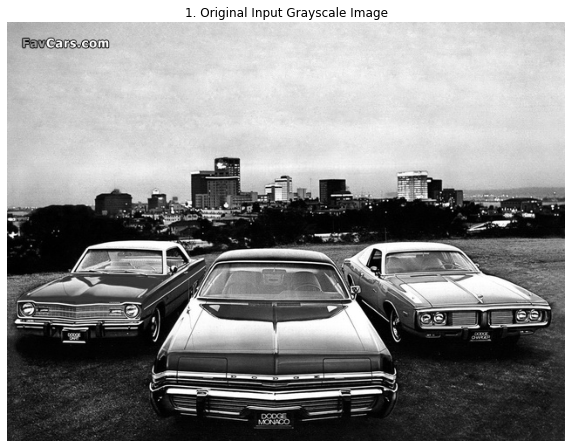

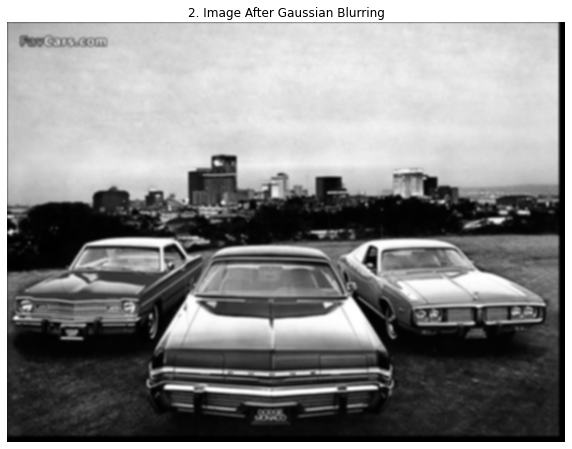

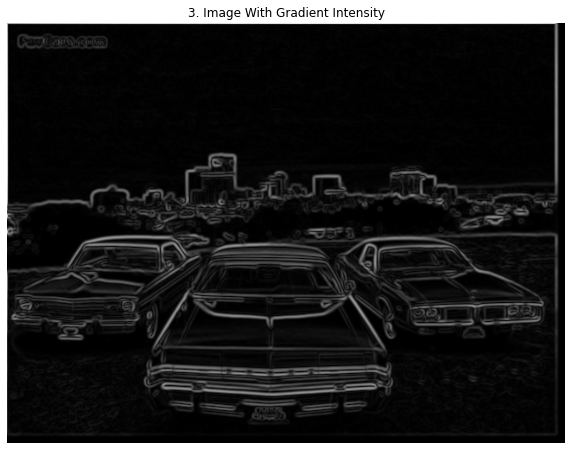

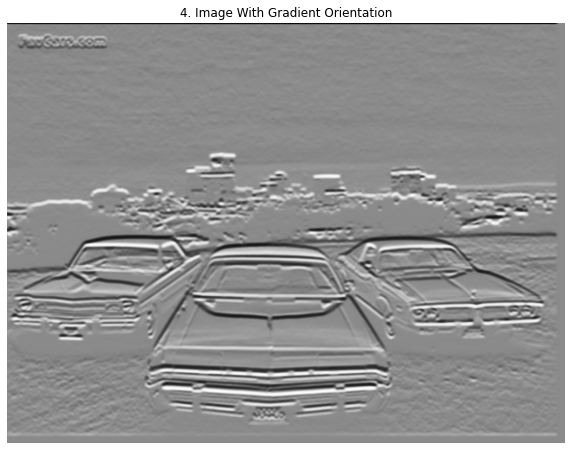

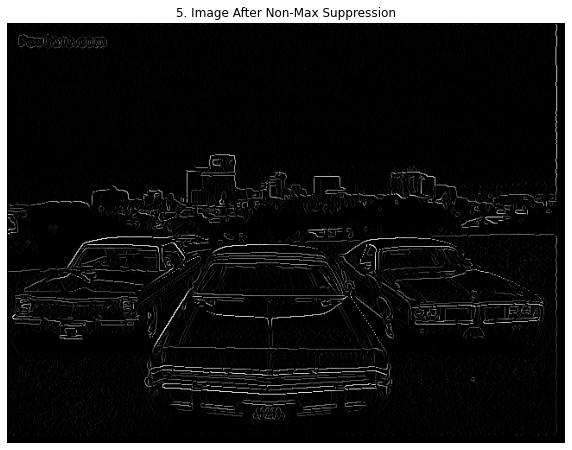

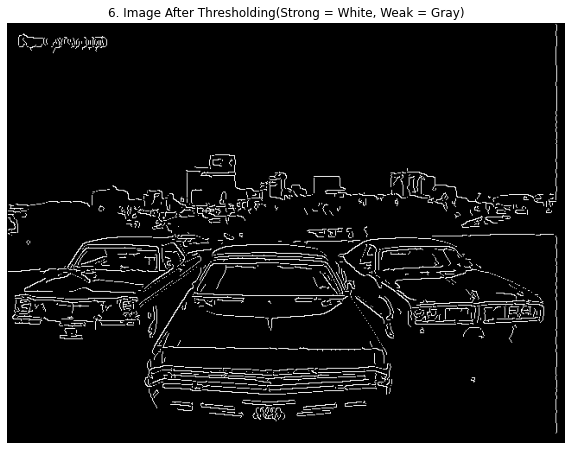

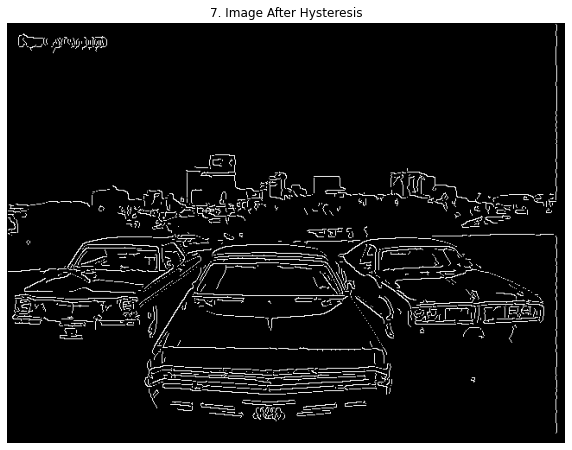

In [ ]:
# Displaying all the intermediate results along with final result of myCannyEdgeDetector() algorithm 
visualize_myCannyEdgeDetector(grayscale_image, convolve_img, gradient_magnitude, gradient_orientation, non_max_supressed_img, thresholded_img, final_img)

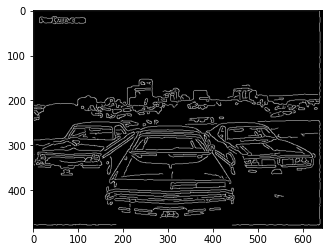

In [ ]:
# Result of inbuilt canny edge detection algorithm of skimage library.
grayscale_image = rgb2gray(input_image)
smoothen_image = GaussianBlur(grayscale_image )
canny_edge_detection_img = feature.canny(smoothen_image, sigma = 1.4, low_threshold = 0.07, high_threshold = 0.24)
plt.imshow(canny_edge_detection_img, cmap = 'gray')

In [ ]:
# Function for calculating PSNR between original output and our algorithm's output.
def PSNR(canny_edge_detection_img, myCannyEdgeDetector_img):
    mse = np.mean(np.square(canny_edge_detection_img - myCannyEdgeDetector_img))
    rmse = np.sqrt(mse)
    if(mse == 0):  
        psnr = 100
        return psnr

    max_p = 255.0
    psnr = 20 * np.log10(max_p / rmse)
    return psnr

In [ ]:
# Calculating PSNR value between original output and our algorithm's output.
canny_edge_detection_img = np.pad(canny_edge_detection_img, pad_width = 1, mode = 'constant', constant_values = (0, 0))
psnr = PSNR(canny_edge_detection_img, final_img)
print('Peak Signal-To-Noise Ratio = {}'.format(psnr))

Peak Signal-To-Noise Ratio = 13.383386031200498


In [ ]:
# Calculating SSIM value between original output and our algorithm's output.
ssim_val = ssim(canny_edge_detection_img, final_img)
print('Structural Similarity Index Measure = {}'.format(ssim_val))

Structural Similarity Index Measure = 0.6286588404837153


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  
